In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import gc
import re
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from joblib import dump, load
import sys
sys.path.append('../')
from utils.visualization import plot_learning_curve
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\automacao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\automacao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\automacao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We are going to use some approaches for sentiment analysis in order to study their performances.

# Dataset
### Large Movie Review Dataset
Downloaded from http://ai.stanford.edu/~amaas/data/sentiment/

In [5]:
pos_train_raw_folder = (Path('..') / 'data' / 'aclImdb_v1/aclImdb/train/pos').resolve()
neg_train_raw_folder = (Path('..') / 'data' / 'aclImdb_v1/aclImdb/train/neg').resolve()
pos_test_raw_folder = (Path('..') / 'data' / 'aclImdb_v1/aclImdb/test/pos').resolve()
neg_test_raw_folder = (Path('..') / 'data' / 'aclImdb_v1/aclImdb/test/neg').resolve()

#Read train data:
pos_train_raw = list()
for file in pos_train_raw_folder.iterdir():
    with open(file, 'r', encoding='utf-8') as f:
        pos_train_raw.append(f.read())
neg_train_raw = list()
for file in neg_train_raw_folder.iterdir():
    with open(file, 'r', encoding='utf-8') as f:
        neg_train_raw.append(f.read())

#Read test data:
pos_test_raw = list()
for file in pos_test_raw_folder.iterdir():
    with open(file, 'r', encoding='utf-8') as f:
        pos_test_raw.append(f.read())

neg_test_raw = list()
for file in neg_test_raw_folder.iterdir():
    with open(file, 'r', encoding='utf-8') as f:
        neg_test_raw.append(f.read())

# Summary

- [Bag of Words (word **occurrences**)](#approach1):
    - Sklearn CountVectorizer (NLTK stopwords) -> Multinomial Naive Bayes
    - [Result](#approach1_result)
    
    
- [Bag of Words (word **counts**)](#approach2):
    - Sklearn CountVectorizer (NLTK stopwords) -> Multinomial Naive Bayes
    - [Result](#approach2_result)
    
    
- [Bag of Words (word **frequencies** -> TF)](#approach3):
    - Sklearn CountVectorizer (NLTK stopwords) -> TfidfTransformer (**without IDF**) -> Multinomial Naive Bayes
    - [Result](#approach3_result)
    

- [Bag of Words (word **frequencies** -> TF + IDF)](#approach4):
    - Sklearn CountVectorizer (NLTK stopwords) -> TfidfTransformer (**with IDF**) -> Multinomial Naive Bayes
    - [Result](#approach4_result)


- [Bag of Words (word **frequencies** -> TF + IDF)](#approach5):
    - Sklearn CountVectorizer (NLTK stopwords + min/maxdf) -> TfidfTransformer (**with IDF**) -> Multinomial Naive Bayes
    - [Result](#approach5_result)


- [Bag of Words (word **frequencies** -> TF + IDF + 2-grams)](#approach6):
    - Sklearn CountVectorizer (NLTK stopwords + min/maxdf + 2-grams) -> TfidfTransformer (**with IDF**) -> Multinomial Naive Bayes
    - [Result](#approach6_result)


- [Bag of Words (word **occurrences**)](#approach7):
    - Sklearn CountVectorizer (NLTK stopwords) -> Bernoulli Naive Bayes
    - [Result](#approach7_result)


- [Model Selection with GridSearchCV](#gridsearch)


- [Study - number of samples](#numbersamples)

TODO - approaches:
- Add study of positive/negative words
- Results visualization

<a id='approach1'></a>
## Bag Of Words (word occurrences)
Sklearn CountVectorizer (NLTK stopwords) -> Multinomial Naive Bayes

In [25]:
word_occur = True

pipe = Pipeline([
    ('countvec', CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=word_occur)),
    ('naivebayes', MultinomialNB())
])

#Prepare train labels:
n_pos_samples_train = len(pos_train_raw)
n_neg_samples_train = len(neg_train_raw)
y_train = np.concatenate((np.ones((n_pos_samples_train)), np.zeros((n_neg_samples_train))))

pipe.fit(pos_train_raw + neg_train_raw, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(binary=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('naivebayes', MultinomialNB())])

<a id='approach1_result'></a>
#### Result

In [26]:
#Prepare test labels:
n_pos_samples_test = len(pos_test_raw)
n_neg_samples_test = len(neg_test_raw)
y_test = np.concatenate((np.ones((n_pos_samples_test)), np.zeros((n_neg_samples_test))))
y_pred = pipe.predict(pos_test_raw + neg_test_raw)

print('Precision: {}'.format(np.round(precision_score(y_test, y_pred), decimals=4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_pred), decimals=4)))
print('Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), decimals=4)))

#Generate list of results for visual comparison:
results = list()
results.append({
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred)
})

Precision: 0.872
Recall: 0.7862
Accuracy: 0.8354


<a id='approach2'></a>
## Bag Of Words (word counts)
Sklearn CountVectorizer (NLTK stopwords) -> Multinomial Naive Bayes

In [27]:
word_occur = False

pipe = Pipeline([
    ('countvec', CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=word_occur)),
    ('naivebayes', MultinomialNB())
])

#Prepare train labels:
n_pos_samples_train = len(pos_train_raw)
n_neg_samples_train = len(neg_train_raw)
y_train = np.concatenate((np.ones((n_pos_samples_train)), np.zeros((n_neg_samples_train))))

pipe.fit(pos_train_raw + neg_train_raw, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('naivebayes', MultinomialNB())])

<a id='approach2_result'></a>
#### Result

In [28]:
#Prepare test labels:
n_pos_samples_test = len(pos_test_raw)
n_neg_samples_test = len(neg_test_raw)
y_test = np.concatenate((np.ones((n_pos_samples_test)), np.zeros((n_neg_samples_test))))
y_pred = pipe.predict(pos_test_raw + neg_test_raw)

print('Precision: {}'.format(np.round(precision_score(y_test, y_pred), decimals=4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_pred), decimals=4)))
print('Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), decimals=4)))

results.append({
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred)
})

Precision: 0.866
Recall: 0.7665
Accuracy: 0.8239


<a id='approach3'></a>
## Bag Of Words (word frequencies -> TF)
Sklearn CountVectorizer (NLTK stopwords) -> TfidfTransformer (without IDF) -> Multinomial Naive Bayes

In [29]:
word_occur = False
use_idf = False

pipe = Pipeline([
    ('countvec', CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=word_occur)),
    ('tfidf', TfidfTransformer(use_idf=use_idf)),
    ('naivebayes', MultinomialNB())
])

#Prepare train labels:
n_pos_samples_train = len(pos_train_raw)
n_neg_samples_train = len(neg_train_raw)
y_train = np.concatenate((np.ones((n_pos_samples_train)), np.zeros((n_neg_samples_train))))

pipe.fit(pos_train_raw + neg_train_raw, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('naivebayes', MultinomialNB())])

<a id='approach3_result'></a>
#### Result

In [30]:
#Prepare test labels:
n_pos_samples_test = len(pos_test_raw)
n_neg_samples_test = len(neg_test_raw)
y_test = np.concatenate((np.ones((n_pos_samples_test)), np.zeros((n_neg_samples_test))))
y_pred = pipe.predict(pos_test_raw + neg_test_raw)

print('Precision: {}'.format(np.round(precision_score(y_test, y_pred), decimals=4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_pred), decimals=4)))
print('Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), decimals=4)))

results.append({
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred)
})

Precision: 0.876
Recall: 0.8134
Accuracy: 0.8492


<a id='approach4'></a>
## Bag Of Words (word frequencies -> TF + IDF)
Sklearn CountVectorizer (NLTK stopwords) -> TfidfTransformer (with IDF) -> Multinomial Naive Bayes

In [31]:
word_occur = False
use_idf = True

pipe = Pipeline([
    ('countvec', CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=word_occur)),
    ('tfidf', TfidfTransformer(use_idf=use_idf)),
    ('naivebayes', MultinomialNB())
])

#Prepare train labels:
n_pos_samples_train = len(pos_train_raw)
n_neg_samples_train = len(neg_train_raw)
y_train = np.concatenate((np.ones((n_pos_samples_train)), np.zeros((n_neg_samples_train))))

pipe.fit(pos_train_raw + neg_train_raw, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer()),
                ('naivebayes', MultinomialNB())])

<a id='approach4_result'></a>
#### Result

In [32]:
#Prepare test labels:
n_pos_samples_test = len(pos_test_raw)
n_neg_samples_test = len(neg_test_raw)
y_test = np.concatenate((np.ones((n_pos_samples_test)), np.zeros((n_neg_samples_test))))
y_pred = pipe.predict(pos_test_raw + neg_test_raw)

print('Precision: {}'.format(np.round(precision_score(y_test, y_pred), decimals=4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_pred), decimals=4)))
print('Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), decimals=4)))

results.append({
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred)
})

Precision: 0.8687
Recall: 0.7875
Accuracy: 0.8342


<a id='approach5'></a>
## Bag Of Words (word frequencies -> TF + IDF)
Sklearn CountVectorizer (NLTK stopwords + min/maxdf) -> TfidfTransformer (with IDF) -> Multinomial Naive Bayes

In [33]:
word_occur = False
use_idf = True
min_df=0.003
max_df=0.98

pipe = Pipeline([
    ('countvec', CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=word_occur, min_df=min_df, max_df=max_df)),
    ('tfidf', TfidfTransformer(use_idf=use_idf)),
    ('naivebayes', MultinomialNB())
])

#Prepare train labels:
n_pos_samples_train = len(pos_train_raw)
n_neg_samples_train = len(neg_train_raw)
y_train = np.concatenate((np.ones((n_pos_samples_train)), np.zeros((n_neg_samples_train))))

pipe.fit(pos_train_raw + neg_train_raw, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(max_df=0.98, min_df=0.003,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer()),
                ('naivebayes', MultinomialNB())])

<a id='approach5_result'></a>
#### Result

In [34]:
#Prepare test labels:
n_pos_samples_test = len(pos_test_raw)
n_neg_samples_test = len(neg_test_raw)
y_test = np.concatenate((np.ones((n_pos_samples_test)), np.zeros((n_neg_samples_test))))
y_pred = pipe.predict(pos_test_raw + neg_test_raw)

print('Precision: {}'.format(np.round(precision_score(y_test, y_pred), decimals=4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_pred), decimals=4)))
print('Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), decimals=4)))

results.append({
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred)
})

Precision: 0.855
Recall: 0.8408
Accuracy: 0.8491


<a id='approach6'></a>
## Bag Of Words (word frequencies -> TF + IDF)
Sklearn CountVectorizer (NLTK stopwords + min/maxdf + 2-grams) -> TfidfTransformer (with IDF) -> Multinomial Naive Bayes

In [35]:
word_occur = False
use_idf = True
min_df=0.003
max_df=0.98
ngram_range = (1, 2)

pipe = Pipeline([
    ('countvec', CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=word_occur, min_df=min_df, max_df=max_df, ngram_range=ngram_range)),
    ('tfidf', TfidfTransformer(use_idf=use_idf)),
    ('naivebayes', MultinomialNB())
])

#Prepare train labels:
n_pos_samples_train = len(pos_train_raw)
n_neg_samples_train = len(neg_train_raw)
y_train = np.concatenate((np.ones((n_pos_samples_train)), np.zeros((n_neg_samples_train))))

pipe.fit(pos_train_raw + neg_train_raw, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(max_df=0.98, min_df=0.003, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer()),
                ('naivebayes', MultinomialNB())])

<a id='approach6_result'></a>
#### Result

In [36]:
#Prepare test labels:
n_pos_samples_test = len(pos_test_raw)
n_neg_samples_test = len(neg_test_raw)
y_test = np.concatenate((np.ones((n_pos_samples_test)), np.zeros((n_neg_samples_test))))
y_pred = pipe.predict(pos_test_raw + neg_test_raw)

print('Precision: {}'.format(np.round(precision_score(y_test, y_pred), decimals=4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_pred), decimals=4)))
print('Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), decimals=4)))

results.append({
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred)
})

Precision: 0.8551
Recall: 0.8612
Accuracy: 0.8576


<a id='approach7'></a>
## Bag Of Words (word occurrences)
Sklearn CountVectorizer (NLTK stopwords) -> Bernoullli Naive Bayes

In [37]:
word_occur = True

pipe = Pipeline([
    ('countvec', CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=word_occur)),
    ('naivebayes', BernoulliNB())
])

#Prepare train labels:
n_pos_samples_train = len(pos_train_raw)
n_neg_samples_train = len(neg_train_raw)
y_train = np.concatenate((np.ones((n_pos_samples_train)), np.zeros((n_neg_samples_train))))

pipe.fit(pos_train_raw + neg_train_raw, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(binary=True,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('naivebayes', BernoulliNB())])

<a id='approach7_result'></a>
#### Result

In [38]:
#Prepare test labels:
n_pos_samples_test = len(pos_test_raw)
n_neg_samples_test = len(neg_test_raw)
y_test = np.concatenate((np.ones((n_pos_samples_test)), np.zeros((n_neg_samples_test))))
y_pred = pipe.predict(pos_test_raw + neg_test_raw)

print('Precision: {}'.format(np.round(precision_score(y_test, y_pred), decimals=4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_pred), decimals=4)))
print('Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), decimals=4)))

results.append({
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred)
})

Precision: 0.8734
Recall: 0.7442
Accuracy: 0.8182


Results from all models:

In [39]:
results

[{'precision': 0.8719723183391004, 'recall': 0.78624, 'accuracy': 0.8354},
 {'precision': 0.8659616775126536, 'recall': 0.76648, 'accuracy': 0.82392},
 {'precision': 0.8760230895149479, 'recall': 0.81344, 'accuracy': 0.84916},
 {'precision': 0.8686904341687257, 'recall': 0.78752, 'accuracy': 0.83424},
 {'precision': 0.8549581062393232, 'recall': 0.8408, 'accuracy': 0.84908},
 {'precision': 0.8551116053697673, 'recall': 0.8612, 'accuracy': 0.85764},
 {'precision': 0.8734391136982443, 'recall': 0.74424, 'accuracy': 0.8182}]

In [40]:
data = pd.DataFrame(results)

In [41]:
data

,precision,recall,accuracy
0,0.871972,0.78624,0.83540
1,0.865962,0.76648,0.82392
2,0.876023,0.81344,0.84916
3,0.868690,0.78752,0.83424
4,0.854958,0.84080,0.84908
5,0.855112,0.86120,0.85764
6,0.873439,0.74424,0.81820


<a id='gridsearch'></a>
## Model Selection with GridSearchCV

In [23]:
parameters = {
    'countvec__binary': (True, False),
    'countvec__min_df': (0.001, 0.002, 0.003),
    'countvec__max_df': (0.90, 0.98),
    'countvec__ngram_range': ((1, 1), (1, 2)),  # unigrams, bigrams
    'tfidf__use_idf': (True, False)
}

pipe = Pipeline([
    ('countvec', CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'))),
    ('tfidf', TfidfTransformer()),
    ('naivebayes', MultinomialNB())
])

#Prepare train labels:
n_pos_samples_train = len(pos_train_raw)
n_neg_samples_train = len(neg_train_raw)
y_train = np.concatenate((np.ones((n_pos_samples_train)), np.zeros((n_neg_samples_train))))

opt = GridSearchCV(pipe, parameters, n_jobs=-1, cv = 10)
opt.fit((pos_train_raw + neg_train_raw), y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('countvec',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your

In [20]:
#saving the GridSearch results:
file_name = 'gridsearchcv.joblib'
path = Path('../models')
dump(opt, path / file_name)

['..\\models\\gridsearchcv.joblib']

In [33]:
opt.best_estimator_

Pipeline(steps=[('countvec',
                 CountVectorizer(binary=True, max_df=0.9, min_df=0.001,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('naivebayes', MultinomialNB())])

In [34]:
opt.best_params_

{'countvec__binary': True,
 'countvec__max_df': 0.9,
 'countvec__min_df': 0.001,
 'countvec__ngram_range': (1, 2),
 'tfidf__use_idf': False}

In [22]:
opt.best_score_

0.8616399999999999

In [12]:
#loading the GridSearch results:
opt = load(Path('../models') / file_name)

Testing the best params on test set (out of sample performance estimation):

In [30]:
#Prepare test labels:
n_pos_samples_test = len(pos_test_raw)
n_neg_samples_test = len(neg_test_raw)
y_test = np.concatenate((np.ones((n_pos_samples_test)), np.zeros((n_neg_samples_test))))
y_pred = opt.best_estimator_.predict(pos_test_raw + neg_test_raw)

print('Precision: {}'.format(np.round(precision_score(y_test, y_pred), decimals=4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_pred), decimals=4)))
print('Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), decimals=4)))

Precision: 0.8734
Recall: 0.8662
Accuracy: 0.8703


<a id='numbersamples'></a>
## Study - number of samples
Here we are interested in the estimation of the number of samples needed to build a predictive model within this problem domain. We will plot the learning curve.

In [17]:
#Best params from GridSearchCV:
word_occur = True
use_idf = False
min_df=0.001
max_df=0.9
ngram_range = (1, 2)

#Separating the Pipeline because we would have to fit the raw data every iteration of the learning curve plotting otherwise.
countvec = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=word_occur, min_df=min_df, max_df=max_df, ngram_range=ngram_range)
tfidf = TfidfTransformer(use_idf=use_idf)
naivebayes = MultinomialNB()

In [18]:
X = countvec.fit_transform(pos_train_raw + pos_test_raw + neg_train_raw + neg_test_raw)
X = tfidf.fit_transform(X)

#Prepare train labels (train data + test data):
n_pos_samples = len(pos_train_raw + pos_test_raw)
n_neg_samples = len(neg_train_raw + neg_test_raw)
y = np.concatenate((np.ones((n_pos_samples)), np.zeros((n_neg_samples))))

<module 'matplotlib' from 'C:\\ProgramData\\Anaconda3\\envs\\movie-sentiment-analysis\\lib\\site-packages\\matplotlib\\__init__.py'>

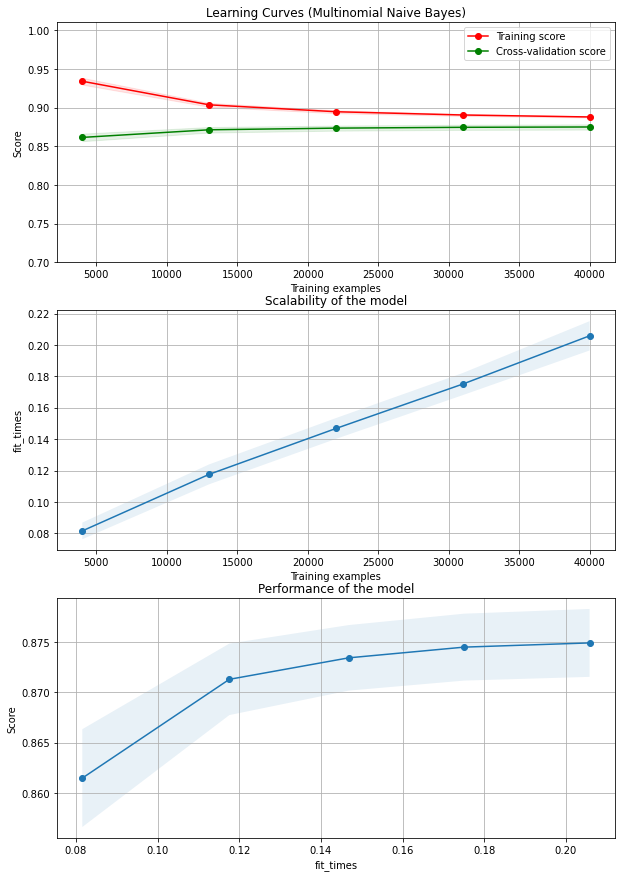

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves (Multinomial Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(naivebayes, title, X, y, axes=axes[:], ylim=(0.7, 1.01), cv=cv, n_jobs=4, shuffle=True)

As we can see, there is not much improvement after around 15000 samples. So, if we are in a situation of few samples within this problem domain, and the cost of getting more samples is high, this estimation helps us to understand the need of more data.

Extra: custom tokenizer

In [23]:
def my_tokenizer(text):
    #tokens = nltk.word_tokenize(text) #separates words like "hasn't" in ["has", "n't'"], and messes up the removal of stop words
    token_pattern = r"(?u)\b\w\w+\b"
    #token_pattern = r'\b\w+\b'
    tokens = re.findall(token_pattern, text)
    #wn = WordNetLemmatizer()
    #out = [wn.lemmatize(token) for token in tokens]
    #stemer = PorterStemmer()
    #out = [stemer.stem(token) for token in tokens]
    return tokens

In [24]:
countvec = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), binary=False, 
                          lowercase=True, tokenizer=my_tokenizer).fit(pos_train_raw + neg_train_raw)